In [93]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from simulation.models.single_codon import single_codon
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

In [94]:
palette = sns.diverging_palette(240, 10, n=4)
trna_color_map = {"TTT_charged": palette[0], "TTT_uncharged": palette[1], "ATA_charged": palette[3], "ATA_uncharged": palette[2]}

def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

def tRNA_species_plot(df):
    df_fil = df[(df.species.str.contains("charged"))]
    sns.lineplot(x="time", y="protein", units="seed", hue="species", palette=trna_color_map, estimator=None, data=df_fil)
    
def ribosome_plot(df):
    df_fil = df[(df.species == "__ribosome")]
    sns.lineplot(x="time", y="protein", units="seed", estimator=None, data=df_fil, color="purple")

In [95]:
from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

In [96]:
def get_average_protein(path, perc_good, time, max_seed):
    df_master = pd.read_csv(f"{path}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    if tmp.empty:
        times = df_master["time"].to_list()
        dedup_times = []
        [dedup_times.append(x) for x in times if x not in dedup_times]
        next_best_time = take_closest(dedup_times, time)
        tmp = df_master.loc[df_master['time'] == next_best_time].groupby(["species"])["protein"].mean().reset_index()
    tmp["optimal_codon_count"] = perc_good
    return tmp

In [97]:
rcParams['figure.figsize'] = [10, 5]

ValueError: Could not interpret value `percent optimal` for parameter `x`

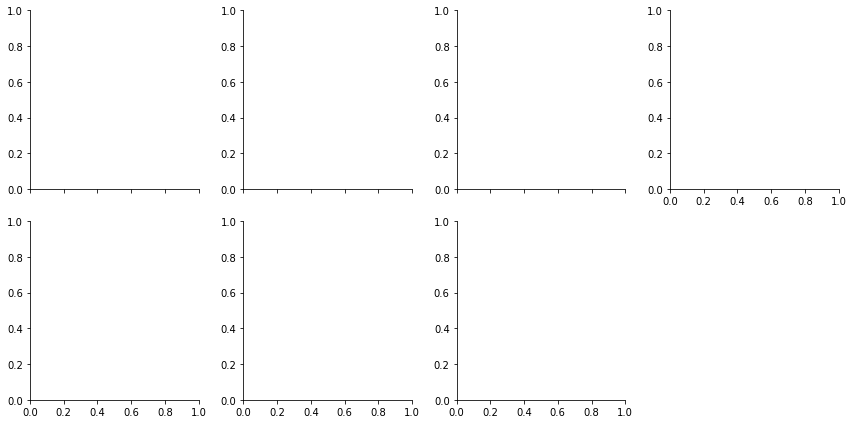

In [111]:
#f = plt.figure(figsize=(15, 10))
#gs = f.add_gridspec(3, 2)

fractions = [10, 25, 40, 50, 60, 75, 85, 90, 95, 99]
count_good = [55, 60, 70, 80, 85, 90, 95, 99]
charging = [10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0]

df_master = None
for count, rate in enumerate(charging):
    df_tmp = None
    for frac in fractions:
        for count in count_good:
            count_bad = 100 - count
            path = f"../output/two_codon_var_trna_ratios_var_charg_fixed_rbs/two_codon_fixed_transcript_{frac}_{count}_{count_bad}_200_1200_5.0_10000.0_{rate}"
            tmp = get_average_protein(path, frac, 500, 3)
            tmp["optimal_tRNA_abundance"] = count
            if df_tmp is not None:
                df_tmp = df_tmp.append(tmp, ignore_index=True)
            else:
                df_tmp = tmp
    df_tmp["tRNA_charging_rate"] = str(rate)
    if df_master is not None:
        df_master = df_master.append(df_tmp, ignore_index=True)
    else:
        df_master = df_tmp
df_master

df_master = df_master[(df_master.species == "proteinX")]
g = sns.FacetGrid(df_master, col="tRNA_charging_rate", col_wrap=4, sharey=False)
g.map_dataframe(sns.lineplot, "percent optimal", "protein", hue="optimal_tRNA_abundance")
#plt.savefig("tRNA_frac_grid_v1.png")

#x, y = (int(count < 3), (count - (3 * (count // 3))))
#ax = f.add_subplot(gs[x, y])
#sns.lineplot(x="percent_good", y="protein", hue="optimal_tRNA_abundance", data=df_fil)
#plt.xlabel("% optimal codon")
#plt.ylabel("proteinX counts")
#f.tight_layout()

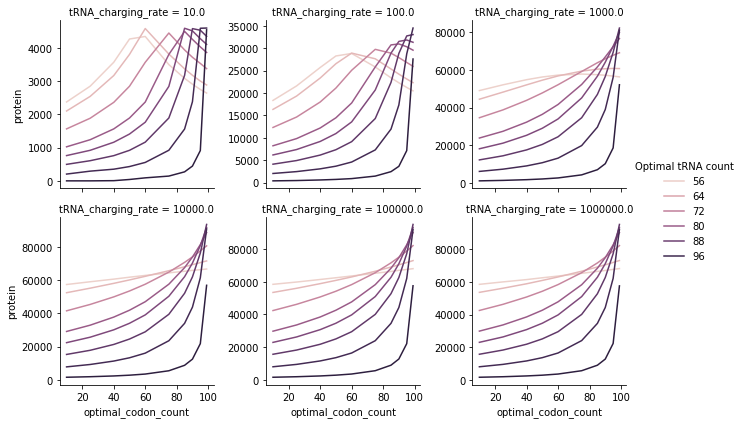

In [112]:
#f = plt.figure(figsize=(15, 10))
#gs = f.add_gridspec(3, 2)

fractions = [10, 25, 40, 50, 60, 75, 85, 90, 95, 99]
count_good = [55, 60, 70, 80, 85, 90, 95, 99]
charging = [10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]

df_master = None
for count, rate in enumerate(charging):
    df_tmp = None
    for frac in fractions:
        for count in count_good:
            count_bad = 100 - count
            path = f"../output/two_codon_var_trna_ratios_var_charg_fixed_rbs/two_codon_fixed_transcript_{frac}_{count}_{count_bad}_200_1200_5.0_100000.0_{rate}"
            tmp = get_average_protein(path, frac, 500, 3)
            tmp["optimal_tRNA_count"] = count
            if df_tmp is not None:
                df_tmp = df_tmp.append(tmp, ignore_index=True)
            else:
                df_tmp = tmp
    df_tmp["tRNA_charging_rate"] = str(rate)
    if df_master is not None:
        df_master = df_master.append(df_tmp, ignore_index=True)
    else:
        df_master = df_tmp
df_master

df_master = df_master[(df_master.species == "proteinX")]
g = sns.FacetGrid(df_master, col="tRNA_charging_rate", col_wrap=3, sharey=False)
g.map_dataframe(sns.lineplot, "optimal_codon_count", "protein", hue="optimal_tRNA_count")
g.add_legend(title="Optimal tRNA count")
plt.savefig("figures_group_mtg_0401/grid.png")

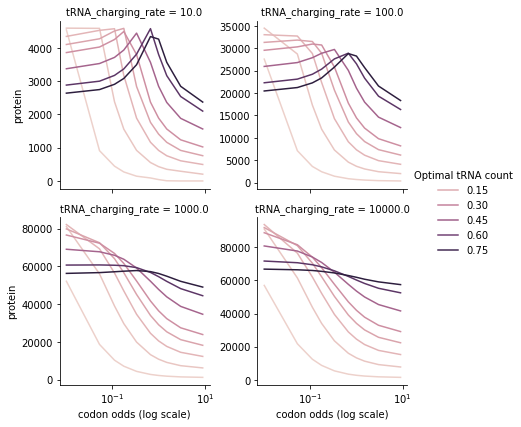

In [114]:
#f = plt.figure(figsize=(15, 10))
#gs = f.add_gridspec(3, 2)

fractions = [10, 25, 40, 50, 60, 75, 85, 90, 95, 99]
count_good = [55, 60, 70, 80, 85, 90, 95, 99]
charging = [10.0, 100.0, 1000.0, 10000.0]

df_master = None
for count, rate in enumerate(charging):
    df_tmp = None
    for frac in fractions:
        for count in count_good:
            count_bad = 100 - count
            path = f"../output/two_codon_var_trna_ratios_var_charg_fixed_rbs/two_codon_fixed_transcript_{frac}_{count}_{count_bad}_200_1200_5.0_100000.0_{rate}"
            tmp = get_average_protein(path, frac, 500, 3)
            tmp["optimal_tRNA_count"] = count
            if df_tmp is not None:
                df_tmp = df_tmp.append(tmp, ignore_index=True)
            else:
                df_tmp = tmp
    df_tmp["tRNA_charging_rate"] = str(rate)
    if df_master is not None:
        df_master = df_master.append(df_tmp, ignore_index=True)
    else:
        df_master = df_tmp
df_master

df_master = df_master[(df_master.species == "proteinX")]
df_master['codon_odds'] = df_master.apply(lambda row: (1/(row.optimal_codon_count/100)) - 1, axis = 1)
df_master['tRNA_odds'] = df_master.apply(lambda row: (1/(row.optimal_tRNA_count/100)) - 1, axis = 1)
g = sns.FacetGrid(df_master, col="tRNA_charging_rate", col_wrap=2, sharey=False)
g.map_dataframe(sns.lineplot, "codon_odds", "protein", hue="tRNA_odds")
g.add_legend(title="Optimal tRNA count")
plt.xscale("log")
g.set_axis_labels("codon odds (log scale)")
plt.savefig("figures_group_mtg_0401/grid_odds.png")

In [116]:
df_chrg_100 = df_master[(df_master['tRNA_charging_rate']  == "100.0")]
#max_protein = df_chrg_100.groupby(['optimal tRNA abundance']).agg(max_protein=("protein", "max"))
max_protein = df_chrg_100.loc[df_chrg_100.groupby(['tRNA_odds']).protein.idxmax()].reset_index()
max_protein
#df_chrg_100

,index,species,protein,optimal_codon_count,optimal_tRNA_count,tRNA_charging_rate,codon_odds,tRNA_odds
0,1119,proteinX,27575.333333,99,99,100.0,0.010101,0.010101
1,1112,proteinX,34484.333333,99,95,100.0,0.010101,0.052632
2,1105,proteinX,33022.000000,99,90,100.0,0.010101,0.111111
3,1042,proteinX,31821.000000,95,85,100.0,0.052632,0.176471
4,979,proteinX,30936.333333,90,80,100.0,0.111111,0.250000
5,860,proteinX,29731.333333,75,70,100.0,0.333333,0.428571
6,797,proteinX,28895.333333,60,60,100.0,0.666667,0.666667
7,790,proteinX,28811.000000,60,55,100.0,0.666667,0.818182


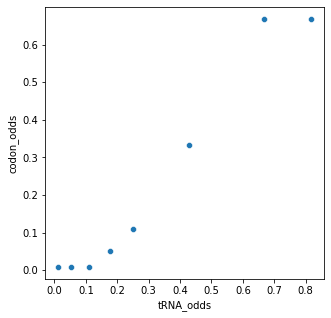

In [121]:
rcParams['figure.figsize'] = [5, 5]
sns.scatterplot(data=max_protein, x="tRNA_odds", y="codon_odds")
plt.savefig("figures_group_mtg_0401/max_protein_odds.png")

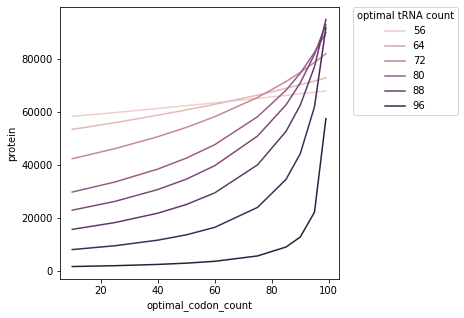

In [110]:
rcParams['figure.figsize'] = [5, 5]
fractions = [10, 25, 40, 50, 60, 75, 85, 90, 95, 99]
count_good = [55, 60, 70, 80, 85, 90, 95, 99]


df_master = None
for frac in fractions:
    for count in count_good:
        count_bad = 100 - count
        path = f"../output/two_codon_var_trna_ratios_var_charg_fixed_rbs/two_codon_fixed_transcript_{frac}_{count}_{count_bad}_200_1200_5.0_100000.0_100000.0"
        tmp = get_average_protein(path, frac, 500, 3)
        tmp["optimal_tRNA_count"] = count
        if df_master is not None:
            df_master = df_master.append(tmp, ignore_index=True)
        else:
            df_master = tmp
#df_master["tRNA charging rate"] = str(rate)


df_master = df_master[(df_master.species == "proteinX")]
#g = sns.FacetGrid(df_master, col="tRNA charging rate", col_wrap=3, sharey=False)
sns.lineplot(data=df_master, x="optimal_codon_count", y="protein", hue="optimal_tRNA_count")
plt.legend(title="optimal tRNA count", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("figures_group_mtg_0401/equal_rbs_charging.png", bbox_inches="tight")

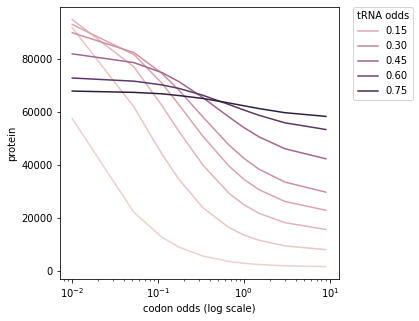

In [108]:
rcParams['figure.figsize'] = [5, 5]
fractions = [10, 25, 40, 50, 60, 75, 85, 90, 95, 99]
count_good = [55, 60, 70, 80, 85, 90, 95, 99]


df_master = None
for frac in fractions:
    for count in count_good:
        count_bad = 100 - count
        path = f"../output/two_codon_var_trna_ratios_var_charg_fixed_rbs/two_codon_fixed_transcript_{frac}_{count}_{count_bad}_200_1200_5.0_100000.0_100000.0"
        tmp = get_average_protein(path, frac, 500, 3)
        tmp["optimal_tRNA_count"] = count
        if df_master is not None:
            df_master = df_master.append(tmp, ignore_index=True)
        else:
            df_master = tmp
#df_master["tRNA charging rate"] = str(rate)


df_master = df_master[(df_master.species == "proteinX")]
df_master['codon_odds'] = df_master.apply(lambda row: (1/(row.optimal_codon_count/100)) - 1, axis = 1)
df_master['tRNA_odds'] = df_master.apply(lambda row: (1/(row.optimal_tRNA_count/100)) - 1, axis = 1)
#g = sns.FacetGrid(df_master, col="tRNA charging rate", col_wrap=3, sharey=False)
sns.lineplot(data=df_master, x="codon_odds", y="protein", hue="tRNA_odds")
plt.xscale("log")
plt.xlabel("codon odds (log scale)")
plt.legend(title="tRNA odds", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("figures_group_mtg_0401/equal_rbs_charging_odds.png", bbox_inches="tight")

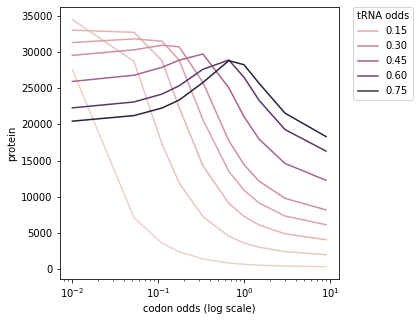

In [105]:
rcParams['figure.figsize'] = [5, 5]
fractions = [10, 25, 40, 50, 60, 75, 85, 90, 95, 99]
count_good = [55, 60, 70, 80, 85, 90, 95, 99]


df_master = None
for frac in fractions:
    for count in count_good:
        count_bad = 100 - count
        path = f"../output/two_codon_var_trna_ratios_var_charg_fixed_rbs/two_codon_fixed_transcript_{frac}_{count}_{count_bad}_200_1200_5.0_100000.0_100.0"
        tmp = get_average_protein(path, frac, 500, 3)
        tmp["optimal_tRNA_count"] = count
        if df_master is not None:
            df_master = df_master.append(tmp, ignore_index=True)
        else:
            df_master = tmp
#df_master["tRNA charging rate"] = str(rate)


df_master = df_master[(df_master.species == "proteinX")]
df_master['codon_odds'] = df_master.apply(lambda row: (1/(row.optimal_codon_count/100)) - 1, axis = 1)
df_master['tRNA_odds'] = df_master.apply(lambda row: (1/(row.optimal_tRNA_count/100)) - 1, axis = 1)
sns.lineplot(data=df_master, x="codon_odds", y="protein", hue="tRNA_odds")
plt.xscale("log")
plt.xlabel("codon odds (log scale)")
plt.legend(title="tRNA odds", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("figures_group_mtg_0401/lower_charging_odds.png", bbox_inches="tight")